In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from xgboost import XGBRFClassifier

from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [2]:
### DEFINE THRESHOLD CLASSIFIER AS SKLEARN COMPATIBLE ESTIMATOR ###

from sklearn.model_selection import train_test_split
from sklearn.base import clone, BaseEstimator, ClassifierMixin


class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, estimator, refit=True, val_size=0.3):
        self.estimator = estimator
        self.refit = refit
        self.val_size = val_size
        
    def fit(self, X, y):
        
        def scoring(th, y, prob):
            pred = (prob > th).astype(int)
            return 0 if not pred.any() else \
                -fbeta_score(y, pred, beta=0.1) 
        
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, stratify=y, test_size=self.val_size, 
            shuffle=True, random_state=1234
        )
        
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X_train, y_train)
        
        prob_val = self.estimator_.predict_proba(X_val)[:,1]
        thresholds = np.linspace(0,1, 200)[1:-1]
        scores = [scoring(th, y_val, prob_val) 
                    for th in thresholds]
        self.score_ = np.min(scores)
        self.th_ = thresholds[np.argmin(scores)]
        
        if self.refit:
            self.estimator_.fit(X, y)
        if hasattr(self.estimator_, 'classes_'):
            self.classes_ = self.estimator_.classes_
            
        return self
    
    def predict(self, X):
        proba = self.estimator_.predict_proba(X)[:,1]
        return (proba > self.th_).astype(int)
    
    def predict_proba(self, X):
        return self.estimator_.predict_proba(X)

In [3]:
### SIMULATE DATA ###

X, y = make_classification(
    n_samples=5_000, 
    class_sep=0.5,
    n_features=30, n_informative=11, n_redundant=6,
    n_classes=2, weights=[0.9, 0.1],  
    random_state=1234, shuffle=True
)

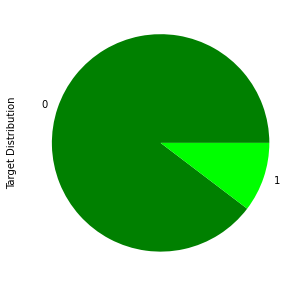

In [4]:
### TARGET DISTRIBUTION OF SIMULATED DATA ###

pd.value_counts(y).rename('Target Distribution').plot.pie(
    colors=['green','lime'], figsize=(5,5)
)
plt.show()

In [5]:
### MODELING VARIABLE ###

CV = StratifiedKFold(5, shuffle=True, random_state=1234)
base_clf = XGBRFClassifier(random_state=1234)
scoring = {
    'fbeta': make_scorer(fbeta_score, beta=0.1), 
    'roc_auc':'roc_auc', 
    'average_precision':'average_precision'
}

In [6]:
### SIMPLE MODEL SELECTION ###

base_model = RandomizedSearchCV(
    base_clf, 
    dict(n_estimators=stats.randint(50,300)), 
    n_iter=20, random_state=1234,
    cv=CV, n_jobs=-1, 
    refit=False, error_score='raise',
    scoring=scoring,
).fit(X, y)

In [7]:
### MODEL SELECTION WITH ThresholdClassifier ###

threshold_model = RandomizedSearchCV(
    ThresholdClassifier(base_clf), 
    dict(estimator__n_estimators=stats.randint(50,300)), 
    n_iter=20, random_state=1234,
    cv=CV, n_jobs=-1, 
    refit=False, error_score='raise',
    scoring=scoring,
).fit(X, y)

In [8]:
### GET CV MEDIAN SCORE RESULTS ###

base_model_test_roc_auc = np.median([
    base_model.cv_results_[f'split{i}_test_roc_auc'] 
    for i in range(CV.n_splits)
], axis=0)
base_model_test_avg_precision = np.median([
    base_model.cv_results_[f'split{i}_test_average_precision'] 
    for i in range(CV.n_splits)
], axis=0)
base_model_test_fbeta = np.median([
    base_model.cv_results_[f'split{i}_test_fbeta'] 
    for i in range(CV.n_splits)
], axis=0)

threshold_model_test_roc_auc = np.median([
    threshold_model.cv_results_[f'split{i}_test_roc_auc'] 
    for i in range(CV.n_splits)
], axis=0)
threshold_model_test_avg_precision = np.median([
    threshold_model.cv_results_[f'split{i}_test_average_precision'] 
    for i in range(CV.n_splits)
], axis=0)
threshold_model_test_fbeta = np.median([
    threshold_model.cv_results_[f'split{i}_test_fbeta'] 
    for i in range(CV.n_splits)
], axis=0)

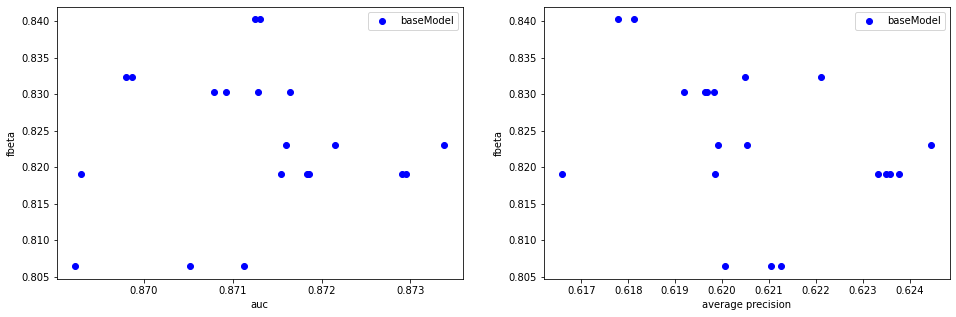

In [9]:
### PLOT SIMPLE MODEL SEARCH RESULTS ###

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.scatter(
    base_model_test_roc_auc,
    base_model_test_fbeta,
    c='blue', label='baseModel'
)
plt.ylabel('fbeta'); plt.xlabel('auc'); plt.legend()

plt.subplot(1,2,2)
plt.scatter(
    base_model_test_avg_precision,
    base_model_test_fbeta,
    c='blue', label='baseModel'
)
plt.ylabel('fbeta'); plt.xlabel('average precision'); plt.legend()

plt.show()

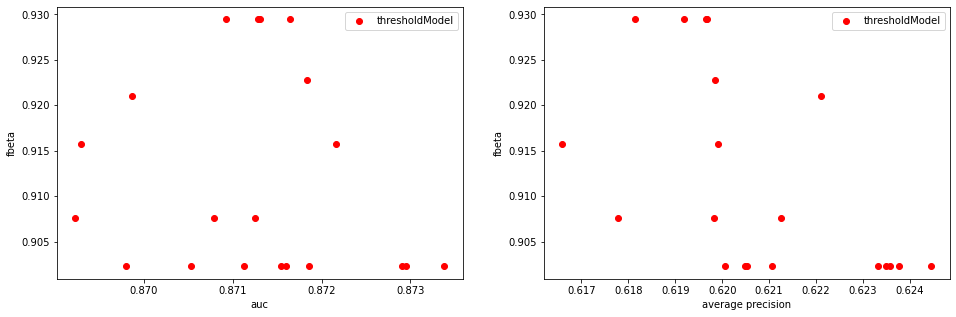

In [10]:
### PLOT ThresholdClassifier SEARCH RESULTS ###

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.scatter(
    threshold_model_test_roc_auc,
    threshold_model_test_fbeta,
    c='red', label='thresholdModel'
)
plt.ylabel('fbeta'); plt.xlabel('auc'); plt.legend()

plt.subplot(1,2,2)
plt.scatter(
    threshold_model_test_avg_precision,
    threshold_model_test_fbeta,
    c='red', label='thresholdModel'
)
plt.ylabel('fbeta'); plt.xlabel('average precision'); plt.legend()

plt.show()

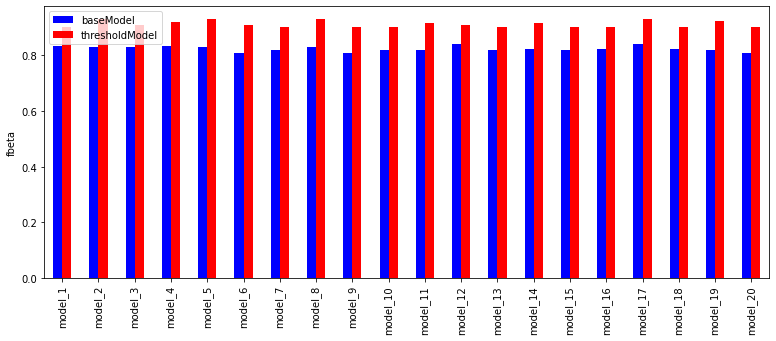

In [11]:
### PLOT SIMPLE MODEL AND ThresholdClassifier SEARCH RESULTS ###

pd.DataFrame(
    {'baseModel': base_model_test_fbeta,
     'thresholdModel': threshold_model_test_fbeta},
    index=[f"model_{m+1}" for m in range(len(base_model.cv_results_['params']))]
).plot.bar(color=['blue','red'], figsize=(13,5))
plt.ylabel('fbeta')
plt.show()

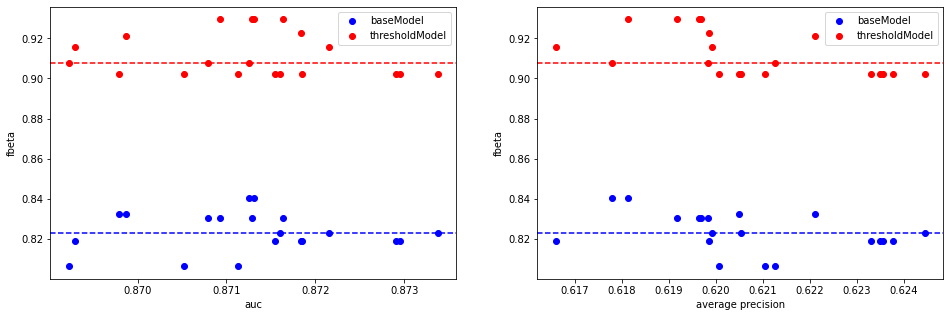

In [12]:
### PLOT SIMPLE MODEL AND ThresholdClassifier SEARCH RESULTS ###

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.scatter(
    base_model_test_roc_auc,
    base_model_test_fbeta,
    c='blue', label='baseModel'
)
plt.scatter(
    threshold_model_test_roc_auc,
    threshold_model_test_fbeta,
    c='red', label='thresholdModel'
)
plt.axhline(np.median(base_model_test_fbeta), 
            color='blue', linestyle='--')
plt.axhline(np.median(threshold_model_test_fbeta), 
            color='red', linestyle='--')
plt.ylabel('fbeta'); plt.xlabel('auc'); plt.legend()

plt.subplot(1,2,2)
plt.scatter(
    base_model_test_avg_precision,
    base_model_test_fbeta,
    c='blue', label='baseModel'
)
plt.scatter(
    threshold_model_test_avg_precision,
    threshold_model_test_fbeta,
    c='red', label='thresholdModel'
)
plt.axhline(np.median(base_model_test_fbeta), 
            color='blue', linestyle='--')
plt.axhline(np.median(threshold_model_test_fbeta), 
            color='red', linestyle='--')
plt.ylabel('fbeta'); plt.xlabel('average precision'); plt.legend()

plt.show()